In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import gzip,pickle
import mytorch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
import matplotlib.pyplot as plt
from time import time

In [3]:
tr,va,te=pickle.load(gzip.open('data/mnist.pkl.gz'),encoding='latin1')

In [4]:
def normalize(x,mean,std): return (x-mean)/std
tr_mean,tr_std=tr[0].mean(),tr[0].std()
tr_mean,tr_std

(0.13044983, 0.3072898)

In [5]:
tr=(normalize(tr[0],tr_mean,tr_std),tr[1])
va=(normalize(va[0],tr_mean,tr_std),va[1])
te=(normalize(te[0],tr_mean,tr_std),te[1])
tr[0].mean(),tr[0].std(),va[0].mean(),va[0].std(),te[0].mean(),te[0].std()

(-3.1638146e-07, 0.99999934, -0.005850922, 0.99243325, 0.005034822, 1.0064359)

In [6]:
tr[0].min(),tr[0].max()

(-0.42451727, 2.8170278)

In [7]:
n_in=te[0].shape[1]
n_out=te[1].max()+1
n_in,n_out

(784, 10)

In [174]:
class Resize(mytorch.Module):
    def forward(self,x): return x.reshape((-1,1,28,28))
class Flatten(mytorch.Module):
    def forward(self,x): return x.reshape((len(x),-1))

# def getm():
#     return mytorch.Seq(
#         Resize() # 784 -> 1x28x28
#         ,mytorch.Conv2d(1,8,5,padding=2,stride=2),mytorch.ReLU() # -> 8x14x14
#         ,mytorch.Conv2d(8,16,3,padding=1,stride=2),mytorch.ReLU() # -> 16x7x7
#         ,mytorch.Conv2d(16,32,3,padding=1,stride=2),mytorch.ReLU() # -> 32x4x4
#         ,mytorch.Conv2d(32,32,3,padding=1,stride=2),mytorch.ReLU() # -> 32x2x2
#         ,Flatten()
#         ,mytorch.Linear(128,10)
#     ).to(mytorch.float32)

def getm():
    return mytorch.Seq(
        Resize() # 784 -> 1x28x28
        ,mytorch.Conv2d(1,8,5,padding=2,stride=2),mytorch.ReLU() #14
        ,mytorch.Conv2d(8,16,3,padding=1,stride=2),mytorch.ReLU() #7
        ,mytorch.Conv2d(16,32,3,padding=1,stride=2),mytorch.ReLU() #4
        ,Flatten()
        ,mytorch.Linear(32*4*4,10)
    ).to(mytorch.float32)

# nh=50
# def getm():
#     return mytorch.Seq(
#         mytorch.Linear(n_in,nh),mytorch.ReLU()
#         ,mytorch.Linear(nh,10)
#     ).to(mytorch.float32)

# def getm():
#     return mytorch.Seq(
#         mytorch.Conv2d(1,20,5),mytorch.ReLU() # 20x24x24
#         ,mytorch.MaxPool2d(2,stride=2) # 20x12x12
#         ,Flatten() # 20*12*12
#         ,mytorch.Linear(20*12*12,100),mytorch.ReLU() # 100
#         ,mytorch.Linear(100,10)
#     ).to(mytorch.float32)

In [175]:
batch_size=100

def getdl(x,y,shuffle=False,first_n=None):
    if first_n: x,y=x[:first_n],y[:first_n]
    x,y=map(mytorch.tensor,[x,y])
    ds=mytorch.TensorDataset(x,y)
    return mytorch.DataLoader(ds,bs=batch_size,shuffle=shuffle)

# mytorch.manual_seed(1)
trdl=getdl(*tr,shuffle=True)
vadl=getdl(*va)
# plt.imshow(next(iter(trdl))[0][3,0],cmap='gray')
m=getm()

In [184]:
class Hook:
    def __call__(self,m,x,out):
        self.out=out.detach()
        self.m=repr(m)
hooks=[Hook() for _ in range(len(m))]
[m[i].add_forward_hook(hooks[i]) for i in range(len(m))]

[None, None, None, None, None]

In [185]:
xb,yb=next(iter(trdl))
y=m(xb).detach_()
y.mean(),y.var()

(tensor(0.13426088, dtype=float32), tensor(2.243127, dtype=float32))

In [186]:
[(h.out.mean(),h.out.var(),h.m) for h in hooks]

[(tensor(5.4790537e-05, dtype=float32),
  tensor(0.9973425, dtype=float32),
  'Resize'),
 (tensor(-0.09207549, dtype=float32),
  tensor(3.6289299, dtype=float32),
  'Conv2d(ch_in=1, ch_out=16, ksize=7, stride=2, padding=0)'),
 (tensor(0.63579684, dtype=float32), tensor(1.2847375, dtype=float32), 'ReLU'),
 (tensor(0.63579684, dtype=float32),
  tensor(1.2847375, dtype=float32),
  'Flatten'),
 (tensor(0.13426088, dtype=float32),
  tensor(2.243127, dtype=float32),
  'Linear(n_in=1936, n_out=10, bias=True)')]

In [187]:
[(p.mean(),p.var()) for p in m.params()]

[(tensor(-0.00937025, dtype=float32, fn=<DivFn>),
  tensor(0.04543664, dtype=float32)),
 (tensor(0., dtype=float32, fn=<DivFn>), tensor(0., dtype=float32)),
 (tensor(7.1415125e-05, dtype=float32, fn=<DivFn>),
  tensor(0.00103117, dtype=float32)),
 (tensor(0., dtype=float32, fn=<DivFn>), tensor(0., dtype=float32))]

In [188]:
opt.zero_grad()
xb,yb=next(iter(trdl))
mytorch.cross_entropy(m(xb),yb).backward()
[(p.grad.mean(),p.grad.var()) for p in m.params()]

[(tensor(0.0092422, dtype=float32), tensor(0.001879, dtype=float32)),
 (tensor(0.04087089, dtype=float32), tensor(0.00175787, dtype=float32)),
 (tensor(1.2776823e-10, dtype=float32), tensor(0.00590472, dtype=float32)),
 (tensor(-1.8626451e-09, dtype=float32), tensor(0.00474868, dtype=float32))]

In [176]:
lr=.1
n_ep=5
opt=mytorch.SGD(m.params(),lr)#,l2_decay=1e-3)

t0=time()
for ep in range(n_ep):
    totloss=0.
    for xb,yb in trdl:
#         print(xb.sum(),yb.sum())
        loss=mytorch.cross_entropy(m(xb),yb)
        totloss+=loss.v*batch_size
#         print(loss)
        loss.backward()
        opt.step()
    print('train loss',totloss/len(trdl))

    with mytorch.no_grad():
#         acc=0.
#         for xb,yb in trdl:
#             yhat=mytorch.log_softmax(m(xb))
#             acc+=(yhat.argmax(axis=1)==yb).sum()
#         print('train accuracy',acc/len(trdl))
        loss=0.
        acc=0.
        for xb,yb in vadl:
            yhat=mytorch.log_softmax(m(xb))
            acc+=(yhat.argmax(axis=1)==yb).sum()
            loss+=mytorch.nll_loss(yhat,yb)*batch_size
        print(acc/len(vadl),loss/len(vadl))
print(time()-t0,'s')

train loss 0.2716324765495956
tensor(0.9665) tensor(0.11675418)
train loss 0.10319340335205197
tensor(0.9772) tensor(0.08239137)
train loss 0.07406692645326257
tensor(0.9762) tensor(0.07890685)
train loss 0.05984215381322429
tensor(0.98) tensor(0.06792582)
train loss 0.051803757895715535
tensor(0.9801) tensor(0.06686085)
55.42579483985901 s


Seq(
  0: Resize
  1: Conv2d(ch_in=1, ch_out=8, ksize=5, stride=2, padding=2)
  2: ReLU
  3: Conv2d(ch_in=8, ch_out=16, ksize=3, stride=2, padding=1)
  4: ReLU
  5: Conv2d(ch_in=16, ch_out=32, ksize=3, stride=2, padding=1)
  6: ReLU
  7: Flatten
  8: Linear(n_in=512, n_out=10, bias=True)
)
tensor(-0.15549999, fn=<NegFn>) tensor(784)
tensor(-0.51645541, fn=<NegFn>) tensor(784)
tensor(-0.84831605, fn=<NegFn>) tensor(784)
tensor(-1.15630702, fn=<NegFn>) tensor(784)
tensor(-1.45844904, fn=<NegFn>) tensor(784)
tensor(-1.74659197, fn=<NegFn>) tensor(784)
tensor(-2.04710911, fn=<NegFn>) tensor(784)
tensor(-2.38294266, fn=<NegFn>) tensor(784)
tensor(-2.71117174, fn=<NegFn>) tensor(784)
tensor(-3.01017555, fn=<NegFn>) tensor(784)
tensor(-3.26862809, fn=<NegFn>) tensor(784)
tensor(-3.51458537, fn=<NegFn>) tensor(784)
tensor(-3.75104481, fn=<NegFn>) tensor(784)
tensor(-3.97320526, fn=<NegFn>) tensor(784)
tensor(-4.205042, fn=<NegFn>) tensor(784)
tensor(-4.46686692, fn=<NegFn>) tensor(784)
tensor(

tensor(-60.22377731, fn=<NegFn>) tensor(784)
tensor(-60.62354996, fn=<NegFn>) tensor(784)
tensor(-61.02725235, fn=<NegFn>) tensor(784)
tensor(-61.43826444, fn=<NegFn>) tensor(784)
tensor(-61.84070932, fn=<NegFn>) tensor(784)
tensor(-62.24852505, fn=<NegFn>) tensor(784)
tensor(-62.6575169, fn=<NegFn>) tensor(784)
tensor(-63.06179883, fn=<NegFn>) tensor(784)
tensor(-63.47254323, fn=<NegFn>) tensor(784)
tensor(-63.88397924, fn=<NegFn>) tensor(784)
tensor(-64.29462924, fn=<NegFn>) tensor(784)
tensor(-64.71209711, fn=<NegFn>) tensor(784)
tensor(-65.12787956, fn=<NegFn>) tensor(784)
tensor(-65.54390374, fn=<NegFn>) tensor(784)
tensor(-65.96559573, fn=<NegFn>) tensor(784)
tensor(-66.37300386, fn=<NegFn>) tensor(784)
tensor(-66.79474658, fn=<NegFn>) tensor(784)
tensor(-67.20422948, fn=<NegFn>) tensor(784)
tensor(-67.62369229, fn=<NegFn>) tensor(784)
tensor(-68.03693361, fn=<NegFn>) tensor(784)
tensor(-68.45927376, fn=<NegFn>) tensor(784)
tensor(-68.86921951, fn=<NegFn>) tensor(784)
tensor(-69.

tensor(-162.11142138, fn=<NegFn>) tensor(784)
tensor(-162.56458093, fn=<NegFn>) tensor(784)
tensor(-163.01906661, fn=<NegFn>) tensor(784)
tensor(-163.4729142, fn=<NegFn>) tensor(784)
tensor(-163.92054246, fn=<NegFn>) tensor(784)
tensor(-164.37335221, fn=<NegFn>) tensor(784)
tensor(-164.82365308, fn=<NegFn>) tensor(784)
tensor(-165.28289654, fn=<NegFn>) tensor(784)
tensor(-165.73632938, fn=<NegFn>) tensor(784)
tensor(-166.18934842, fn=<NegFn>) tensor(784)
tensor(-166.64181383, fn=<NegFn>) tensor(784)
tensor(-167.08526329, fn=<NegFn>) tensor(784)
tensor(-167.53804983, fn=<NegFn>) tensor(784)
tensor(-167.99229721, fn=<NegFn>) tensor(784)
tensor(-168.44545617, fn=<NegFn>) tensor(784)
tensor(-168.90102387, fn=<NegFn>) tensor(784)
tensor(-169.34848535, fn=<NegFn>) tensor(784)
tensor(-169.80265193, fn=<NegFn>) tensor(784)
tensor(-170.24777654, fn=<NegFn>) tensor(784)
tensor(-170.70259084, fn=<NegFn>) tensor(784)
tensor(-171.1532591, fn=<NegFn>) tensor(784)
tensor(-171.60017705, fn=<NegFn>) te

tensor(-265.88264946, fn=<NegFn>) tensor(784)
tensor(-266.34006697, fn=<NegFn>) tensor(784)
tensor(-266.79719935, fn=<NegFn>) tensor(784)
tensor(-267.25387833, fn=<NegFn>) tensor(784)
tensor(-267.71097328, fn=<NegFn>) tensor(784)
tensor(-268.16451473, fn=<NegFn>) tensor(784)
tensor(-268.62715728, fn=<NegFn>) tensor(784)
tensor(-269.08462858, fn=<NegFn>) tensor(784)
tensor(-269.55242828, fn=<NegFn>) tensor(784)
tensor(-270.01089151, fn=<NegFn>) tensor(784)
tensor(-270.47910467, fn=<NegFn>) tensor(784)
tensor(-270.94732972, fn=<NegFn>) tensor(784)
tensor(-271.40982239, fn=<NegFn>) tensor(784)
tensor(-271.86639718, fn=<NegFn>) tensor(784)
tensor(-272.33089347, fn=<NegFn>) tensor(784)
tensor(-272.80098282, fn=<NegFn>) tensor(784)
tensor(-273.2643295, fn=<NegFn>) tensor(784)
tensor(-273.72861207, fn=<NegFn>) tensor(784)
tensor(-274.18536149, fn=<NegFn>) tensor(784)
tensor(-274.64053552, fn=<NegFn>) tensor(784)
tensor(-275.10485195, fn=<NegFn>) tensor(784)
tensor(-275.57974192, fn=<NegFn>) t

tensor(-376.17313586, fn=<NegFn>) tensor(784)
tensor(-376.64787081, fn=<NegFn>) tensor(784)
tensor(-377.12070498, fn=<NegFn>) tensor(784)
tensor(-377.59787494, fn=<NegFn>) tensor(784)
tensor(-378.08053626, fn=<NegFn>) tensor(784)
tensor(-378.54972161, fn=<NegFn>) tensor(784)
tensor(-379.02487628, fn=<NegFn>) tensor(784)
tensor(-379.50013885, fn=<NegFn>) tensor(784)
tensor(-379.98158964, fn=<NegFn>) tensor(784)
tensor(-380.45120098, fn=<NegFn>) tensor(784)
tensor(-380.92955576, fn=<NegFn>) tensor(784)
tensor(-381.40147025, fn=<NegFn>) tensor(784)
tensor(-381.87748744, fn=<NegFn>) tensor(784)
tensor(-382.35149494, fn=<NegFn>) tensor(784)
tensor(-382.82995841, fn=<NegFn>) tensor(784)
tensor(-383.30210717, fn=<NegFn>) tensor(784)
tensor(-383.78194922, fn=<NegFn>) tensor(784)
tensor(-384.25343715, fn=<NegFn>) tensor(784)
tensor(-384.73281771, fn=<NegFn>) tensor(784)
tensor(-385.20055081, fn=<NegFn>) tensor(784)
tensor(-385.68588271, fn=<NegFn>) tensor(784)
tensor(-386.1617594, fn=<NegFn>) t

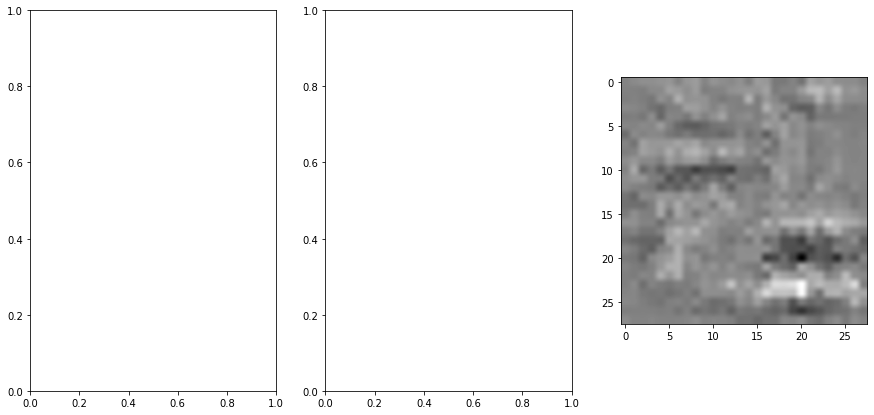

In [189]:
idx=(0,2)
fi=0
fx,fy=3,3
# idx=(0,fi,fx,fy)
# mytorch.manual_seed(1)
m1=mytorch.Seq(*m[:]).do_grad_(False);print(m1)
a=0.
while a==0.:
#     x1=mytorch.randn(1,784,do_grad=True)
    x1=mytorch.rand(1,784,do_grad=True)
#     x1=mytorch.normal(0,0.02,(1,784),do_grad=True)
#     x1=mytorch.tensor(tr[0][None,30871],do_grad=True)
#     x1=mytorch.zeros((1,784),do_grad=True)
#     x1=mytorch.ones((1,784),do_grad=True)
    a=m1(x1)[idx]
x1_0=x1.clone().detach_()
lr1=.1
n_ep1=1000
opt1=mytorch.SGD([x1],lr1)#,l2_decay=0.001)
for _ in range(n_ep1):
    a=-m1(x1)[idx]
    print(a,end=' ')
    a.backward()
    print((x1.grad!=0.).sum())
    opt1.step()
#     plt.imshow(x1.reshape((28,28))[:7,:7].v,cmap='gray')
#     plt.show()
# n=9
# xa0=x1_0.reshape((28,28))[:n,:n]
# xa=x1.reshape((28,28))[:n,:n]
# print(xa0.histc(min=-3,max=3))
# print(xa.histc(min=-3,max=3))
_,ax=plt.subplots(1,3,figsize=(15,7))
# ax[0].imshow(xa0,cmap='gray')
# ax[1].imshow(xa,cmap='gray')
ax[2].imshow(x1.reshape((28,28))*tr_std+tr_mean,cmap='gray',interpolation='hanning')

In [75]:
y1=m1(mytorch.tensor(tr[0][:]))[:,idx[1]]
y1.max(),y1.argsort(axis=None)[-5:]#//16

(tensor(28.050325, dtype=float32), tensor([20060,  4044, 37043,  5801, 30871]))

In [68]:
y1[46753]

tensor(25.994253, dtype=float32)

tensor(28.050323, dtype=float32, fn=<GetItemFn>)


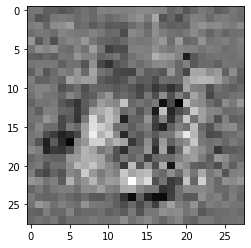

In [78]:
x1=mytorch.tensor(tr[0][None,30871],do_grad=True)
a=m1(x1)[idx];print(a)
a.backward()
g=x1.grad
g
plt.imshow(g.reshape((28,28)),cmap='gray')#,vmin=0.,vmax=.5)

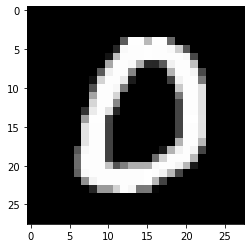

In [76]:
plt.imshow(tr[0][30871].reshape((28,28)),cmap='gray')

In [14]:
import torchvision.models as models
resnet = models.resnet18(pretrained=True).requires_grad_(False).eval()
#resnet

In [249]:
m=nn.Sequential(*list(resnet.children())[:8])
m

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [12]:
def toimg01(x):
    assert len(x.shape)==3
    assert x.shape[0]==3
    x=x.clone().detach_()
    for c in range(len(x)):
        a,b=x[c].min(),x[c].max()
        print(a,b)
        x[c]-=a
        x[c]/=b-a
#         print(x[c].min(),x[c].max())
    return x.permute(1,2,0)

In [30]:
c=151
sz=300
x=(torch.randn(1,3,sz,sz)/10).requires_grad_()
# x=torch.zeros(1,3,sz,sz,requires_grad=True)
# x=im.clone().requires_grad_()

In [17]:
m(x).shape

torch.Size([1, 512, 10, 10])

tensor(-3.4468, grad_fn=<NegBackward>)
tensor(-11.4455, grad_fn=<NegBackward>)
tensor(-16.6008, grad_fn=<NegBackward>)
tensor(-22.3296, grad_fn=<NegBackward>)
tensor(-24.1451, grad_fn=<NegBackward>)
tensor(-29.7143, grad_fn=<NegBackward>)
tensor(-35.8113, grad_fn=<NegBackward>)
tensor(-39.8640, grad_fn=<NegBackward>)
tensor(-45.2572, grad_fn=<NegBackward>)
tensor(-48.8288, grad_fn=<NegBackward>)
tensor(-1.1522) tensor(1.1414)
tensor(-1.1875) tensor(1.2020)
tensor(-1.0113) tensor(1.0731)


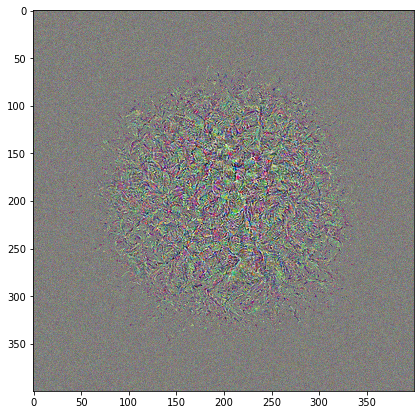

In [284]:
epochs=5
lr=.1
idx=(0,2,6,6)
opt=optim.SGD([x],lr=lr)#,weight_decay=.01)
for _ in range(epochs):
    a=-m(x)[idx]
    print(a)
    a.backward()
    x.grad[(-.03<x.grad)&(x.grad<.03)]=0.
    opt.step()
    opt.zero_grad()

plt.figure(figsize=(15,7))
plt.imshow(toimg01(x[0]))

In [290]:
x=(torch.randn(1,3,sz,sz)/10).requires_grad_()

0.07309480756521225 2.783345431089401e-06 0.012160176849365234
0.08525776863098145
0.07277853041887283 2.787487953901291e-06 0.012219575500488283
0.0850008949637413
0.07235633581876755 2.791996113955975e-06 0.012269506072998048
0.0846286341547966
0.0720122829079628 2.7965258806943897e-06 0.012316157531738281
0.08433123677968979
0.07170619070529938 2.8008857741951945e-06 0.012361888122558595
0.08407087624073029
0.07142501324415207 2.805351465940476e-06 0.012406700134277344
0.08383452147245407
0.0711592435836792 2.8097640722990038e-06 0.012450422668457032
0.08361247181892395
0.07090739905834198 2.8140150010585784e-06 0.01249313201904297
0.08340334892272949
0.07067031413316727 2.8182951733469963e-06 0.012534799194335939
0.08320792764425278
0.07044393569231033 2.8226256370544435e-06 0.012575762939453125
0.08302251994609833
0.07022783160209656 2.8269473463296894e-06 0.012616142272949219
0.08284679800271988
0.07002176344394684 2.8312308713793754e-06 0.012655747985839844
0.082680344581604
0.0

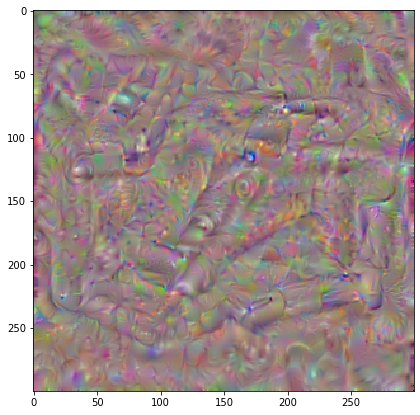

In [309]:
epochs=50
lr=.0001
decay=1e-4
alpha=6
beta=2
lambda_b=1e-4

opt=optim.Adam([x],lr=lr)
rep0=m(im)
rep0_norm=(rep0**2).sum()
for _ in range(epochs):
    diff=((m(x)-rep0)**2).sum()/rep0_norm
    norm=(x**alpha).sum()
    tv=(((x[:,:,:-1,1:]-x[:,:,:-1,:-1])**2+
         (x[:,:,1:,:-1]-x[:,:,:-1,:-1])**2)**(beta/2.)).sum()
    print(diff.item(),decay*norm.item(),lambda_b*tv.item())
    loss=diff+decay*norm+lambda_b*tv
    print(loss.item())
    loss.backward()
    opt.step()
    opt.zero_grad()

plt.figure(figsize=(15,7))
plt.imshow(toimg01(x[0]))

In [307]:
resnet(x).max(),resnet(im).max(),resnet(x).argmax(),resnet(im).argmax()

(tensor(10.9704, grad_fn=<MaxBackward1>),
 tensor(11.4351),
 tensor(742),
 tensor(742))

In [8]:
from PIL import Image

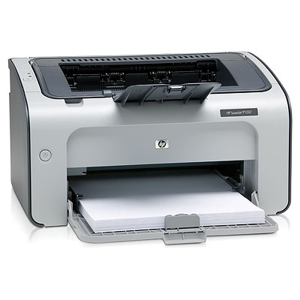

In [266]:
im=Image.open('/home/fil/dl/printer.jpg').resize((300,300))
im

In [268]:
import torchvision.transforms as T
im=torch.from_numpy(np.asarray(im).astype('float32').transpose(2,0,1)/255)
im=T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])(im)
im=im[None]

tensor(-2.1179) tensor(2.2489)
tensor(-2.0357) tensor(2.4286)
tensor(-1.8044) tensor(2.6400)


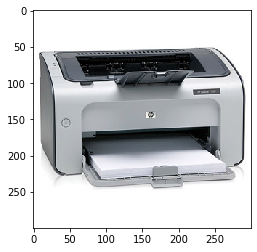

In [269]:
plt.imshow(toimg01(im[0]))